In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from json import load
import tifffile
from tqdm import tqdm
from skimage.draw import polygon
from matplotlib import rcParams
import glasbey

palette = {
    "green": "#558150",
    "beige": "#F1E2C3",
    "brown": "#A7785A",
    "pink": "#F0D6C2",
    "black": "#0E0E0E",
}

rcParams['font.family'] = 'sans-serif'
rcParams['figure.facecolor'] = "#FFFFFF00"
rcParams['axes.facecolor'] = "#FFFFFF00"
rcParams['legend.framealpha'] = 0.2
rcParams['axes.edgecolor'] = palette["black"]
rcParams['axes.labelcolor'] = palette["black"]
rcParams['xtick.color'] = palette["black"]
rcParams['ytick.color'] = palette["black"]
rcParams['text.color'] = palette["black"]
rcParams['axes.titlecolor'] = palette["black"]

s_palette = sns.cubehelix_palette(as_cmap=True)

In [9]:
from src.utils.tracklets import import_tracklets

roots = ["embryo007", "embryo008", "embryo014a", "embryo016", "embryo018"]
datapath = Path().cwd().parent / "data" / "interim" / "confocal"
plotpath = datapath / "ms2_plots"
plotpath.mkdir(exist_ok=True)

spots, tracklets, metadatas, tracklets_joined = import_tracklets(datapath, roots)
for root in roots:
    spots[root]["e_id"] = [f"{root}_{idx}" for idx in spots[root].ID]
    spots[root]["e_parent_id"] = [f"{root}_{idx}" for idx in spots[root].parent_id]
    spots[root]["e_track_id"] = [f"{root}_{idx}" for idx in spots[root].track_id]
    spots[root]["e_tracklet_id"] = [f"{root}_{idx}" for idx in spots[root].tracklet_id]
    spots[root]["embryo"] = root
    spots[root]["d_poles"] = 0.5 - np.abs(spots[root].ap_position - 0.5)
    
    for categorical_col in ["e_id", "e_parent_id", "e_track_id", "e_tracklet_id", "embryo", "track_id", "tracklet_id"]:
        spots[root][categorical_col] = pd.Categorical(spots[root][categorical_col])
    
spots_joined = pd.concat(spots.values(), ignore_index=True)
spots_joined.set_index("e_id", inplace=True)
spots_joined["e_id"] = spots_joined.index
print(spots_joined.columns)
print(tracklets_joined.columns)

Index(['Unnamed: 0', 'ID', 'track_id', 'tracklet_id', 'distance_from_edge',
       'parent_id', 'daughter_id', 'roi', 'FRAME', 'POSITION_X', 'POSITION_Y',
       'POSITION_Z', 'ELLIPSE_MAJOR', 'ELLIPSE_MINOR', 'ELLIPSE_THETA',
       'ELLIPSE_Y0', 'ELLIPSE_X0', 'ELLIPSE_ASPECTRATIO', 'CIRCULARITY',
       'AREA', 'SHAPE_INDEX', 'MEDIAN_INTENSITY_CH1', 'time', 'um_from_edge',
       'um_x', 'um_y', 'ap_position', 'edge_position', 'track_n_tracklets',
       'cycle', 'e_parent_id', 'e_track_id', 'e_tracklet_id', 'embryo',
       'd_poles', 'e_id'],
      dtype='object')
Index(['start_time', 'end_time', 'start_frame', 'end_frame', 'length',
       'source_spot', 'sink_spot', 'mean_ap_position', 'source_ap_position',
       'sink_ap_position', 'initial_x', 'initial_y', 'final_x', 'final_y',
       'initial_x_um', 'initial_y_um', 'final_x_um', 'final_y_um', 'track_id',
       'mean_edge_distance', 'track_n_tracklets', 'cycle', 'embryo',
       'tracklet_id', 'parent_tracklet', 'n_children',

In [16]:
print(metadatas)

{'embryo007': {'name': 'embryo007', 'frames_per_minute': 4, 'pixels_per_um': 3, 'a_x': -20, 'a_y': 240, 'p_x': 1390, 'p_y': 806, 'h': 1360, 'w': 1360, 'n_divisions': 4, 'division_times': [0, 7, 53, 105, 182]}, 'embryo008': {'name': 'embryo008', 'frames_per_minute': 4, 'pixels_per_um': 3, 'a_x': -20, 'a_y': 440, 'p_x': 1410, 'p_y': 870, 'h': 1360, 'w': 1360, 'n_divisions': 4, 'division_times': [0, 29, 73, 124, 198]}, 'embryo014a': {'name': 'embryo014a', 'frames_per_minute': 4, 'pixels_per_um': 3, 'a_x': -50, 'a_y': 150, 'p_x': 1410, 'p_y': 1000, 'h': 1360, 'w': 1360, 'n_divisions': 4, 'division_times': [0, 21, 65, 115, 190]}, 'embryo016': {'name': 'embryo016', 'frames_per_minute': 6, 'pixels_per_um': 3, 'a_x': 0, 'a_y': 245, 'p_x': 1350, 'p_y': 940, 'h': 1360, 'w': 1360, 'n_divisions': 4, 'division_times': [0, 16, 81, 160, 279]}, 'embryo018': {'name': 'embryo018', 'frames_per_minute': 6, 'pixels_per_um': 3, 'a_x': -25, 'a_y': 180, 'p_x': 1380, 'p_y': 1070, 'h': 1360, 'w': 1360, 'n_divis

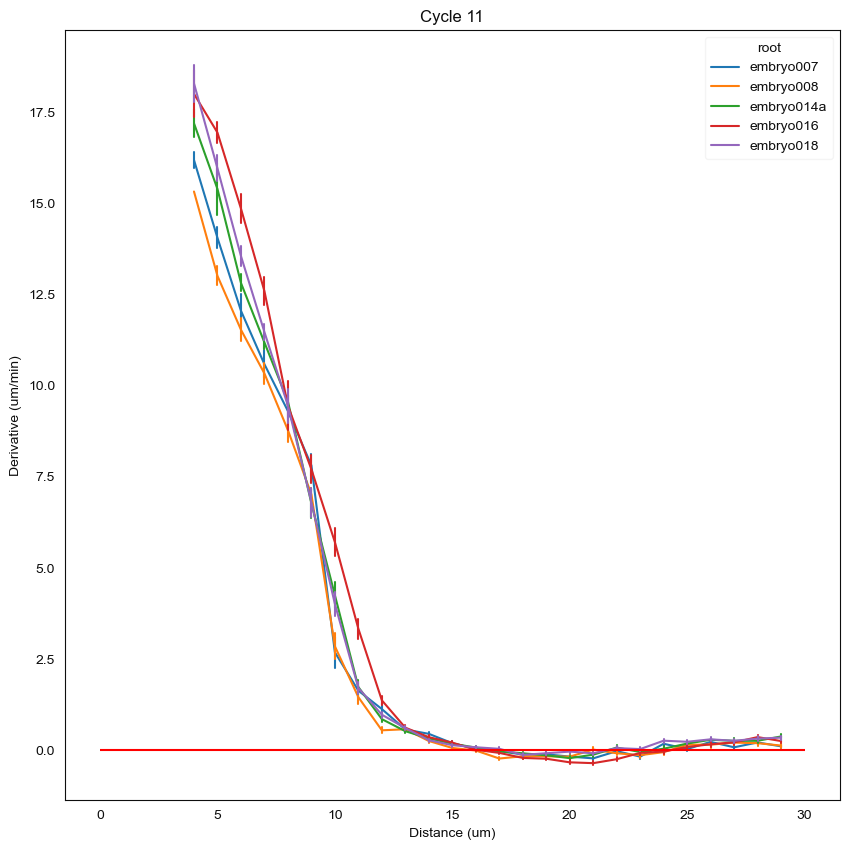

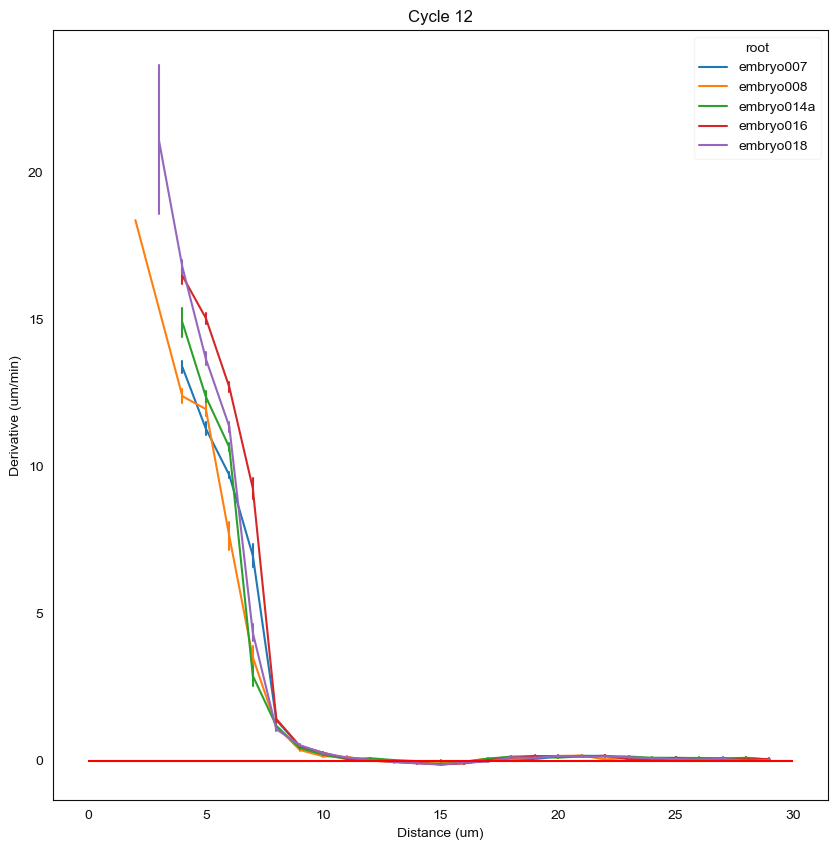

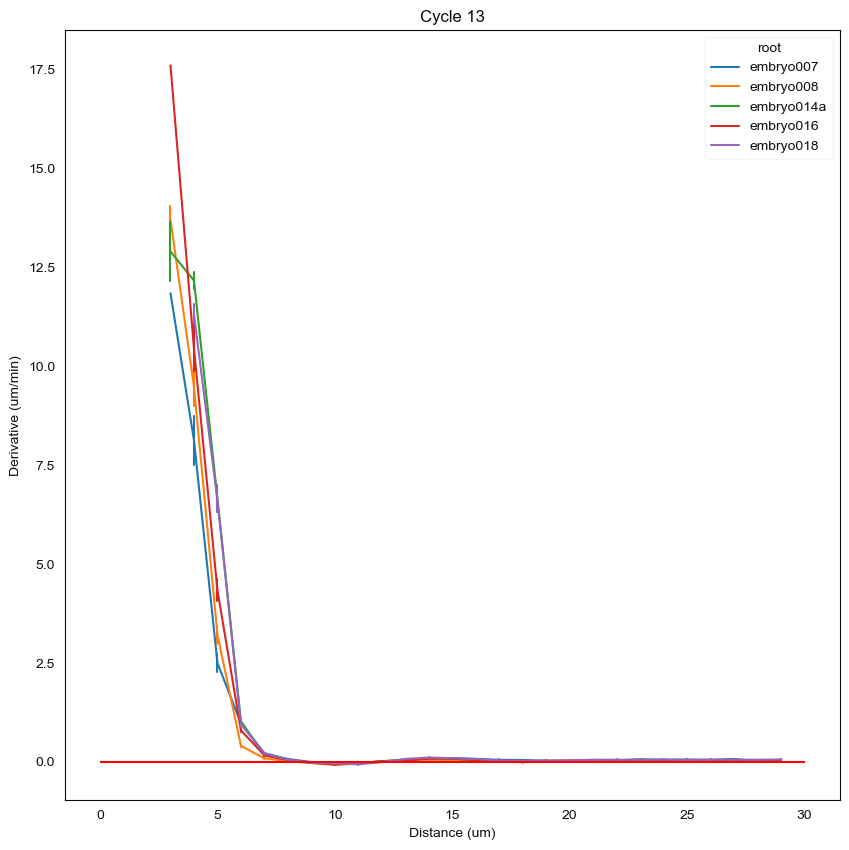

In [18]:
from scipy.spatial.distance import cdist

# 54s to run

for cycle in [11, 12, 13]:
    all_distances = []
    all_derivatives = []
    root_labels = []
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    for root in roots:
        spot_df = spots[root].query(f"cycle == {cycle}")
        spot_df = spot_df[spot_df["track_n_tracklets"] == 31].copy()
        spot_df.set_index("ID", inplace=True)
        spot_df["ID"] = spot_df.index
        
        cycle_tracklets = spot_df["tracklet_id"].unique()
        distances = []
        
        for frame in sorted(spot_df["FRAME"].unique()):
            frame_spots = spot_df.query(f"FRAME == {frame}")
            if len(frame_spots) < 15:
                continue
            positions = frame_spots.groupby("tracklet_id", observed=True)[["um_x", "um_y"]].last().to_dict()
            x = [positions["um_x"].get(tracklet, np.nan) for tracklet in list(cycle_tracklets)]
            y = [positions["um_y"].get(tracklet, np.nan) for tracklet in list(cycle_tracklets)]
            
            distances.append(cdist(np.array([x, y]).T, np.array([x, y]).T))
            
        distances = np.array(distances)
        distance_derivatives = np.diff(distances, axis=0)
        
        # print(distances.shape, distance_derivatives.shape)
        distance_derivatives[(np.abs(distance_derivatives) > 10)] = np.nan
        
        distances_binned = np.floor(distances[:-1].flatten())
        distance_der_flat = distance_derivatives.flatten() * metadatas[root]["frames_per_minute"]
        
        all_distances.extend(distances_binned)
        all_derivatives.extend(distance_der_flat)
        root_labels.extend([root] * len(distances_binned))
        
        
    within_dis = (np.abs(all_distances) < 30) & (np.array(all_distances) > 0)
    df = pd.DataFrame({"distances": np.array(all_distances)[within_dis], "derivative": np.array(all_derivatives)[within_dis], "root": np.array(root_labels)[within_dis]})
    sns.lineplot(df, x="distances", y="derivative", ax=ax, errorbar="se", hue="root", err_style="bars")
    plt.hlines(0, 0, 30, color="red")
    ax.set_title(f"Cycle {cycle}")
    plt.xlabel("Distance (um)")
    plt.ylabel("Derivative (um/min)")
    plt.show()
        
    

         ap_change  edge_change
count  1519.000000  1519.000000
mean      0.031836     0.003682
std       0.020254     0.016351
min      -0.022962    -0.045653
25%       0.017271    -0.007334
50%       0.031428     0.003196
75%       0.045107     0.014979
max       0.091593     0.053974


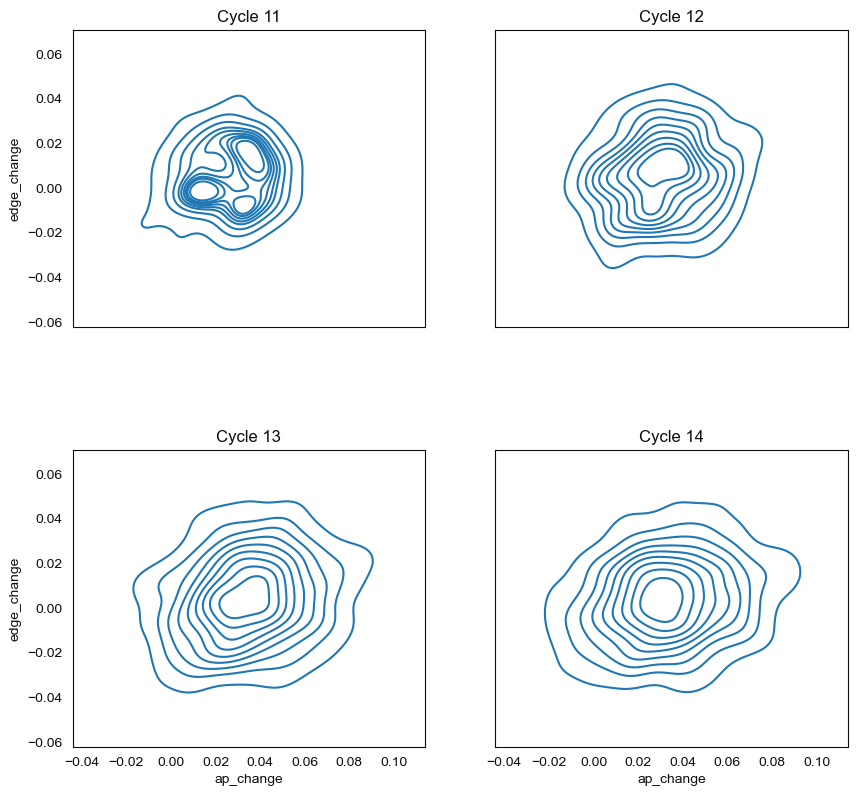

cycle
10    0.071337
11    0.118234
12    0.130326
13    0.141681
14    0.146153
Name: ap_change, dtype: float64


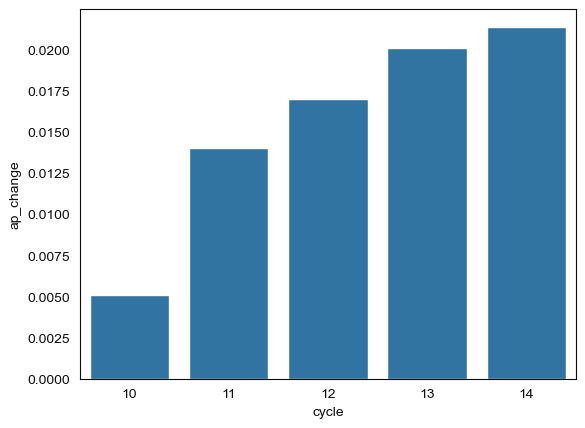

In [59]:
root = "embryo014a"
cycle = 12

spots_df = spots[root]
spots_df = spots_df[spots_df["track_n_tracklets"] == 31].copy()
# last_spots = spots_df.query(f"cycle == {cycle}")

last_spots = spots_df.groupby("tracklet_id", observed=True).last()
last_spots["first_ap"] = last_spots["track_id"].map(spots_df.groupby("track_id", observed=True)["ap_position"].first().astype(float))
last_spots["first_edge"] =  last_spots["track_id"].map(spots_df.groupby("track_id", observed=True)["edge_position"].first().astype(float))

last_spots["ap_change"] = last_spots["ap_position"] - last_spots["first_ap"]
last_spots["ap_change"] = last_spots["ap_change"].clip(-.1, .1)
last_spots["edge_change"] = last_spots["edge_position"] - last_spots["first_edge"]
last_spots["edge_change"] = last_spots["edge_change"].clip(-.1, .1)

print(last_spots[["ap_change", "edge_change"]].describe())

fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
for cycle, ax in zip([11, 12, 13, 14], axes.flatten()):
    sns.kdeplot(data=last_spots[last_spots["cycle"] == cycle], x="ap_change", y="edge_change", ax=ax)
    ax.set_aspect("equal")
    ax.set_title(f"Cycle {cycle}")
    
plt.show()
sns.barplot(last_spots.groupby("cycle")["ap_change"].std())
print(np.sqrt(last_spots.groupby("cycle")["ap_change"].std()))
# sns.barplot(last_spots.groupby("cycle")["edge_change"].std())